# Exploratory Data Analysis (Time & Gambles)

We are going to be looking for patterns in players who only played in the month of June. This is with the purpose to distinguish players between short and long positions, and the reasons why they hold this positions. 

In [2]:
# import all necesary libraries for the project
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Define working directory
path = "/Users/mau/Library/CloudStorage/Dropbox/Mac/Documents/Dissertation/Chapter 2/Entire_Data/By month/1_Generic"
os.chdir(path)

# Filter Columns
filter = ['playerkey', 'playercashableamt', 'wageredamt', 'maxbet', 'grosswin',
       'currencyinamt', 'assetnumber', 'theoreticalpaybackpercent', 
       'age', 'rank', 'gender', 'date', 'start_time', 'end_time', 'duration',
       'slotdenomination']
# Import data
dtf = pd.read_parquet('month_6_year_2015.parquet', columns=filter)

# Check data
dtf.columns

# Select only the rows where duration is greater than or equal to zero
dtf = dtf[dtf['duration'] >= pd.Timedelta(0)]

In [4]:
# Sort data by start_time and playerkey
dtf = dtf.sort_values(by=['playerkey', 'date', 'start_time'])

## Calculate Foundamental Variables

The following variables were calculated using existing data:
* _player_loss_: how much money each player has lost in each gamble.
* _player_wins_: equals the amount of money they bet plus how much they won.
* _percent_return_: the return in player's bets for each gamble played. 

$$\text{percent return} = (\frac{df[wins] - df[wageredamt]}{df[wageredamt]})*100$$

* _playercashableamt_pct_change_: calculates the rate of change of player's outstanding gambling amount. 

$$\text{playercashableamt \% change} = (\frac{df[playercashableamt_{t+1}] - df[playercashableamt_{t}]}{df[playercashableamt_{t}]})*100$$

In [5]:
# Crate a new colum that is the inverse of casino_grosswin, named "player_loss"
dtf['ops'] = dtf['grosswin']*-1

# Create a new column that is the inverse of casino_grosswin, named "player_loss" that includes all negative values of 'ops'
dtf['player_loss'] = np.where(dtf['ops'] < 0, dtf['ops'], 0)

# Create a new column that is the inverse of casino_grosswin, named "player_wins" that includes all positive values of 'ops'
dtf['player_wins'] = np.where(dtf['ops'] > 0, dtf['ops'], 0)

# Create total_amt_won column
dtf['total_amt_won'] = dtf["wageredamt"]+dtf["ops"]

# Create colum profit
dtf['profit'] = dtf['total_amt_won'] - dtf['wageredamt']

# # Calculate percentage return for each gamble and add it as a new column
dtf["percent_return"] = ((dtf["wageredamt"]+dtf["ops"]) - dtf["wageredamt"]) / dtf["wageredamt"] * 100

# # Create a time series variable for each player that starts at 1 and increases by 1 for each row
draw_condition = dtf['grosswin'] == 0

for i, row in dtf.iterrows():
    if draw_condition[i]:
        dtf.loc[i, 'profit'] = 0

# Drop 'ops' column
dtf = dtf.drop(columns=['ops'])

# Create a time series variable for each player that starts at 1 and increases by 1 for each row
dtf["gambles"] = dtf.groupby("playerkey").cumcount() + 1

### Calulates Number of Visits

In [6]:
# Group the DataFrame by playerkey
groups = dtf.groupby('playerkey')

# Initialize the visit column to 1 for the first visit of each player
dtf['visit'] = groups['date'].transform(lambda x: (x.diff().dt.days >= 1).cumsum() + 1)

# Reset the visit count for each new player
dtf['visit'] = dtf.groupby('playerkey')['visit'].apply(lambda x: x - x.iloc[0] + 1)


### Calculate Sessions based on Time

If there is a pause of 30 minutes or more between gambles it is considered the end of a session, and the start of a new one.

In [7]:
# Convert the start_time column to datetime
dtf["start_time"] = pd.to_datetime(dtf["start_time"])

# Sort data by start_time and playerkey
dtf = dtf.sort_values(by=['playerkey', 'date', 'start_time'])

# Compute the time difference between consecutive gambles for each player
dtf['time_diff'] = dtf.groupby('playerkey')['start_time'].diff()

# Initialize the session_time column to 1 for the first gamble of each player
dtf['session_time'] = dtf.groupby('playerkey').ngroup() + 1

# Update the session_time column based on the time difference
dtf['session_time'] += (dtf['time_diff'] > pd.Timedelta(minutes=30)).cumsum()

# Reset the session_time count for each new visit
dtf['session_time'] = dtf.groupby(['playerkey', 'visit'])['session_time'].apply(lambda x: x - x.iloc[0] + 1)

# Remove the temporary time_diff column
dtf = dtf.drop('time_diff', axis=1)

### Calculate Sessions based on Machine Change

Everytime a player switches machine a new sessions begins.

In [8]:
# Initialize the session_machine column to 1 for the first machine of each player
dtf['session_machine'] = (dtf.groupby("playerkey")["assetnumber"].diff() != 0).cumsum()

# Reset the session_machine count for each new visit
dtf['session_machine'] = dtf.groupby(['playerkey', 'visit'])['session_machine'].apply(lambda x: x - x.iloc[0] + 1)


### Calculate the number of gambles per Visit

In [9]:
# Create a column named "gambles_visit" that is the number of gambles per visit
dtf["gambles_visit"] = dtf.groupby(["playerkey", "visit"])["gambles"].cumcount() + 1

# Reset the gambles_visit count for each new visit
dtf['gambles_visit'] = dtf.groupby(['playerkey', 'visit'])['gambles_visit'].apply(lambda x: x - x.iloc[0] + 1)


### Calculate the number of gambles per Session Time

In [10]:
# Create a column named "gambles_session" that is the number of gambles per session
dtf["gambles_session"] = dtf.groupby(["playerkey", "session_time"])["gambles"].cumcount() + 1

# Reset the gambles_session count for each new session
dtf['gambles_session'] = dtf.groupby(['playerkey', 'session_time'])['gambles_session'].apply(lambda x: x - x.iloc[0] + 1)


### Calculate the number of gambles per Session Machine

In [11]:
# Create a column named "gambles_machine" that is the number of gambles per session_machine
dtf["gambles_machine"] = dtf.groupby(["playerkey", "session_machine"])["gambles"].cumcount() + 1

# Reset the gambles_machine count for each new session_machine
dtf['gambles_machine'] = dtf.groupby(['playerkey', 'session_machine'])['gambles_machine'].apply(lambda x: x - x.iloc[0] + 1)

### Calculate the number of Machine Changes


In [12]:
# Create a column called change_machine that is 1 everytime a player changes assetnumber 0 otherwise, grouped by playerkey and session_time
dtf['machines_played'] = (dtf.groupby(['playerkey', 'session_time'])['assetnumber'].diff() != 0).astype(int)

# Percentiles

## Overall Gambles

In [13]:
# Calculate the number of gambles per each player, and store it in a list
gambles_per_player = []
for i in dtf["playerkey"].unique().tolist():
    gambles_per_player.append(dtf[dtf["playerkey"] == i]["gambles"].max())

# Calculate the first quartile of the number of gambles per player and store is as first_quartile
first_quartile = np.percentile(gambles_per_player, 25)
print("First quartile of the number of gambles per player:", first_quartile)

# Calculate the second quartile of the number of gambles per player and store is as second_quartile
second_quartile = np.percentile(gambles_per_player, 50)
print("Second quartile of the number of gambles per player:", second_quartile)

# Calculate the third quartile of the number of gambles per player and store is as third_quartile
third_quartile = np.percentile(gambles_per_player, 75)
print("Third quartile of the number of gambles per player:", third_quartile)

# Calculate the fourth quartile of the number of gambles per player and store is as fourth_quartile
fourth_quartile = np.percentile(gambles_per_player, 100)
print("Fourth quartile of the number of gambles per player:", fourth_quartile)


First quartile of the number of gambles per player: 61.25
Second quartile of the number of gambles per player: 150.0
Third quartile of the number of gambles per player: 340.5
Fourth quartile of the number of gambles per player: 3106.0


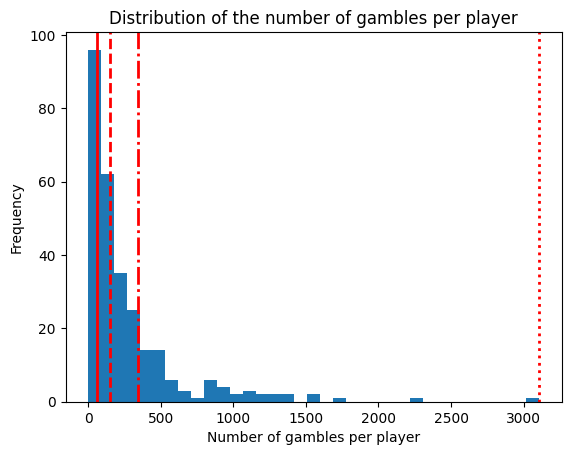

In [17]:
# Plot the distribution of the number of gambles per player
plt.hist(gambles_per_player, bins=35)
# Plot the first quartile as a vertical line
plt.axvline(first_quartile, color='r', linestyle='solid', linewidth=2)
# Plot the second quartile as a vertical line
plt.axvline(second_quartile, color='r', linestyle='dashed', linewidth=2)
# Plot the third quartile as a vertical line
plt.axvline(third_quartile, color='r', linestyle='dashdot', linewidth=2)
# Plot the fourth quartile as a vertical line
plt.axvline(fourth_quartile, color='r', linestyle='dotted', linewidth=2)
plt.xlabel("Number of gambles per player")
plt.ylabel("Frequency")
plt.title("Distribution of the number of gambles per player")
plt.show()


In [24]:
# Let's create two separarte dataframes for the top 20% and bottom 20% of players by creating a list of player for each percentile
extreme_r = dtf.groupby("playerkey")["gambles"].max()[dtf.groupby("playerkey")["gambles"].max() >= third_quartile].index.tolist()
high_r = dtf.groupby("playerkey")["gambles"].max()[(dtf.groupby("playerkey")["gambles"].max() < third_quartile) & (dtf.groupby("playerkey")["gambles"].max() >= second_quartile)].index.tolist()
low_r = dtf.groupby("playerkey")["gambles"].max()[(dtf.groupby("playerkey")["gambles"].max() < second_quartile) & (dtf.groupby("playerkey")["gambles"].max() >= first_quartile)].index.tolist()
minimum_r = dtf.groupby("playerkey")["gambles"].max()[dtf.groupby("playerkey")["gambles"].max() < first_quartile].index.tolist()

# How many players are in extreme_r?
print("# of playes in extreme_r:", len(extreme_r))

# How many players are in high_r?
print("# of players in high_r:", len(high_r))

# How many players are in low_r?
print("# of players in low_r:", len(low_r))

# How many players are in minimum_r?
print("# of players in minimum_r:", len(minimum_r))

# Create a dataframe for the extreme_r players
dtf_extreme_r = dtf[dtf["playerkey"].isin(extreme_r)]
dtf_extreme_r['clasification'] = "extreme_r"

# Create a dataframe for the high_r players
dtf_high_r = dtf[dtf["playerkey"].isin(high_r)]
dtf_high_r['clasification'] = "high_r"

# Create a dataframe for the low_r players
dtf_low_r = dtf[dtf["playerkey"].isin(low_r)]
dtf_low_r['clasification'] = "low_r"

# Create a dataframe for the minimum_r players
dtf_minimum_r = dtf[dtf["playerkey"].isin(minimum_r)]
dtf_minimum_r['clasification'] = "minimum_r"

#  Concatenate all the dataframes into one
dtf_r = pd.concat([dtf_extreme_r, dtf_high_r, dtf_low_r, dtf_minimum_r])

# of playes in extreme_r: 81
# of players in high_r: 67
# of players in low_r: 67
# of players in minimum_r: 67


# Save Dataframes

In [25]:
# Define saving path
path = "/Users/mau/Library/CloudStorage/Dropbox/Mac/Documents/Dissertation/Chapter 2/Entire_Data/By month/2_June"
os.chdir(path)

# General Dataframe to parquet
dtf_r.to_parquet("classification.parquet", engine="pyarrow")
